# **GRU Models**

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from keras_tuner import Hyperband
import pandas as pd
import json

In [5]:
# Load the JSON file
with open('DeteksiSarkasme.json', 'r') as file:
    data = [json.loads(line) for line in file]

df = pd.DataFrame(data)

In [6]:
# Display a sample from the dataset
print(df.head())

                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [7]:
# Encoding the target labels
encoder = LabelEncoder()
df['is_sarcastic'] = encoder.fit_transform(df['is_sarcastic'])

In [8]:
# Split the data into training and testing sets
X = df['headline'].values
y = df['is_sarcastic'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Preprocess the text data using TensorFlow tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [10]:
# Define the GRU model in PyTorch
class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        gru_out, _ = self.gru(x)
        gru_out = gru_out[:, -1, :]
        x = self.fc(gru_out)
        return self.sigmoid(x)

In [11]:
# PyTorch Model Training Function with accuracy and loss tracking
def train_pytorch_model(model, criterion, optimizer, train_data, train_labels, val_data, val_labels, num_epochs=5, batch_size=64):
    model.train()

    # Lists to store loss and accuracy for visualization
    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        correct_predictions = 0
        total_predictions = 0

        # Training loop
        for i in range(0, len(train_data), batch_size):
            inputs = torch.tensor(train_data[i:i+batch_size]).long()
            labels = torch.tensor(train_labels[i:i+batch_size]).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

        # Calculate average loss and accuracy for this epoch
        avg_loss = epoch_loss / (len(train_data) // batch_size)
        accuracy = correct_predictions / total_predictions * 100

        # Append loss and accuracy for training
        train_loss_list.append(avg_loss)
        train_accuracy_list.append(accuracy)

        # Validation loop
        model.eval()  # Switch to evaluation mode
        with torch.no_grad():
            val_loss = 0
            correct_predictions = 0
            total_predictions = 0
            for i in range(0, len(val_data), batch_size):
                inputs = torch.tensor(val_data[i:i+batch_size]).long()
                labels = torch.tensor(val_labels[i:i+batch_size]).float().view(-1, 1)
                outputs = model(inputs)

                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                predicted = (outputs > 0.5).float()
                correct_predictions += (predicted == labels).sum().item()
                total_predictions += labels.size(0)

            avg_val_loss = val_loss / (len(val_data) // batch_size)
            val_accuracy = correct_predictions / total_predictions * 100

            # Append loss and accuracy for validation
            val_loss_list.append(avg_val_loss)
            val_accuracy_list.append(val_accuracy)

        # Print stats for the epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%, '
              f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

In [12]:
# Set up the PyTorch model
input_dim = len(tokenizer.word_index) + 1
embedding_dim = 100
hidden_dim = 128
output_dim = 1
model_pytorch = GRUModel(input_dim, embedding_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_pytorch.parameters(), lr=0.001)

In [13]:
# Train the PyTorch model and get the loss and accuracy for each epoch
train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list = train_pytorch_model(
    model_pytorch, criterion, optimizer, X_train_pad, y_train, X_test_pad, y_test, num_epochs=5)

Epoch 1/5, Train Loss: 0.5103, Train Accuracy: 73.51%, Val Loss: 0.4470, Val Accuracy: 79.11%
Epoch 2/5, Train Loss: 0.3537, Train Accuracy: 84.35%, Val Loss: 0.4059, Val Accuracy: 82.14%
Epoch 3/5, Train Loss: 0.2558, Train Accuracy: 89.57%, Val Loss: 0.4174, Val Accuracy: 82.97%
Epoch 4/5, Train Loss: 0.1720, Train Accuracy: 93.56%, Val Loss: 0.4818, Val Accuracy: 83.36%
Epoch 5/5, Train Loss: 0.1091, Train Accuracy: 96.20%, Val Loss: 0.5755, Val Accuracy: 83.23%


In [14]:
# Plot the loss and accuracy curves for PyTorch with validation
def plot_metrics(train_loss, train_accuracy, val_loss, val_accuracy):
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Training Accuracy', color='green')
    plt.plot(val_accuracy, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

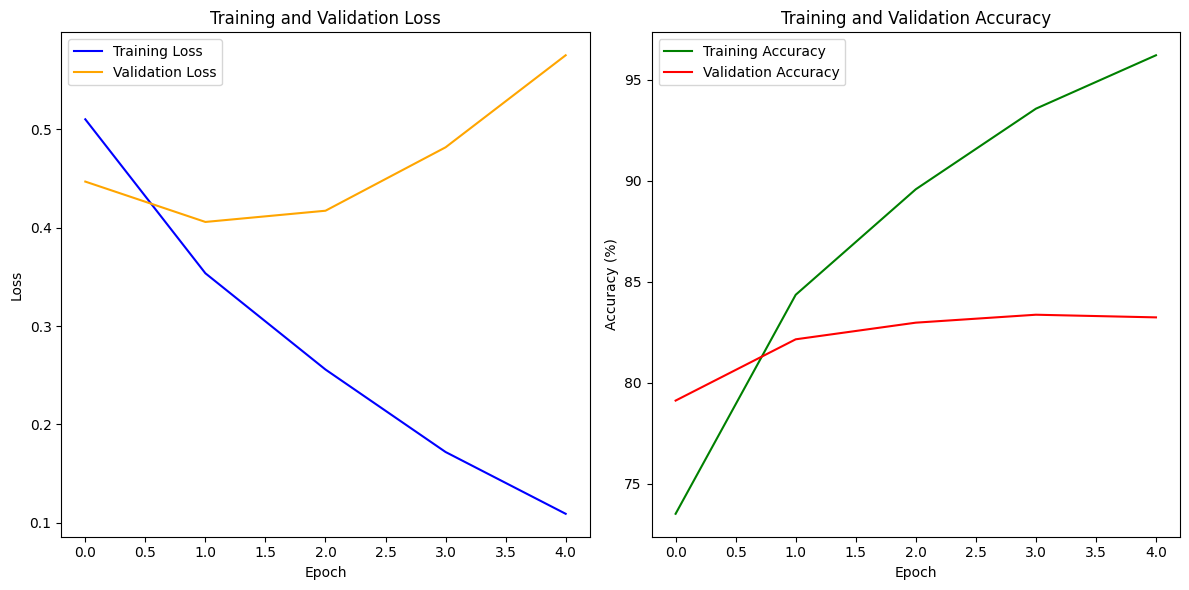

In [15]:
# Call the plotting function for PyTorch
plot_metrics(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list)

In [16]:
# Evaluate the PyTorch model
model_pytorch.eval()
y_pred_pytorch = model_pytorch(torch.tensor(X_test_pad).long()).detach().numpy()
y_pred_pytorch = (y_pred_pytorch > 0.5).astype(int)

# Metrics Calculation for PyTorch
print("PyTorch Accuracy:", accuracy_score(y_test, y_pred_pytorch))
print("PyTorch Precision:", precision_score(y_test, y_pred_pytorch))
print("PyTorch Recall:", recall_score(y_test, y_pred_pytorch))
print("PyTorch F1 Score:", f1_score(y_test, y_pred_pytorch))
print("PyTorch AUC:", roc_auc_score(y_test, y_pred_pytorch))

PyTorch Accuracy: 0.832272557094721
PyTorch Precision: 0.8280542986425339
PyTorch Recall: 0.7800511508951407
PyTorch F1 Score: 0.8033362598770851
PyTorch AUC: 0.8266076849268761


In [17]:
# TensorFlow GRU Model
def create_gru_model(input_dim, embedding_dim, hidden_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim, embedding_dim, input_length=max_len),
        tf.keras.layers.GRU(hidden_dim),
        tf.keras.layers.Dense(output_dim, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [18]:
# Hyperparameter Tuning with Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim, hp.Int('embedding_dim', min_value=50, max_value=200, step=50), input_length=max_len),
        tf.keras.layers.GRU(hp.Int('gru_units', min_value=50, max_value=200, step=50)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [19]:
# Initialize Hyperband tuner
tuner = Hyperband(build_model, objective='val_accuracy', max_epochs=10, factor=3, directory='my_dir', project_name='sarcasm_detection')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
# Fit the model using Hyperband
tuner.search(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test))

Trial 2 Complete [00h 07m 42s]
val_accuracy: 0.8635342717170715

Best val_accuracy So Far: 0.8650318384170532
Total elapsed time: 00h 12m 10s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
50                |200               |embedding_dim
200               |100               |gru_units
0.0040901         |0.0010872         |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
 17/668 ━━━━━━━━━━━━━━━━━━━━ 1:41 156ms/step - accuracy: 0.5821 - loss: 0.6746

KeyboardInterrupt: 

In [22]:
# Get the best model from Hyperband
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
# Evaluate the TensorFlow model
y_pred_tensorflow = best_model.predict(X_test_pad)
y_pred_tensorflow = (y_pred_tensorflow > 0.5).astype(int)

# Metrics Calculation for TensorFlow
print("TensorFlow Accuracy:", accuracy_score(y_test, y_pred_tensorflow))
print("TensorFlow Precision:", precision_score(y_test, y_pred_tensorflow))
print("TensorFlow Recall:", recall_score(y_test, y_pred_tensorflow))
print("TensorFlow F1 Score:", f1_score(y_test, y_pred_tensorflow))
print("TensorFlow AUC:", roc_auc_score(y_test, y_pred_tensorflow))

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
TensorFlow Accuracy: 0.8650318232871583
TensorFlow Precision: 0.8248700519792083
TensorFlow Recall: 0.8793691389599319
TensorFlow F1 Score: 0.8512481947596452
TensorFlow AUC: 0.8665871061955868


In [26]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 200)       │     5,307,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100)            │        90,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,193,705 (61.77 MB)

 Trainable params: 5,397,901 (20.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,795,804 (41.18 MB)

In [24]:
# Plot Accuracy and Loss for TensorFlow
def plot_metrics(history):
    # Plot accuracy
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Model Accuracy')
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Model Loss')
    plt.show()

Epoch 1/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 133s 196ms/step - accuracy: 0.9315 - loss: 0.1798 - val_accuracy: 0.8641 - val_loss: 0.3373
Epoch 2/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 130s 194ms/step - accuracy: 0.9669 - loss: 0.0904 - val_accuracy: 0.8553 - val_loss: 0.4214
Epoch 3/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 130s 195ms/step - accuracy: 0.9855 - loss: 0.0438 - val_accuracy: 0.8443 - val_loss: 0.6149
Epoch 4/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 129s 194ms/step - accuracy: 0.9914 - loss: 0.0237 - val_accuracy: 0.8398 - val_loss: 0.8003
Epoch 5/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 129s 194ms/step - accuracy: 0.9951 - loss: 0.0163 - val_accuracy: 0.8394 - val_loss: 0.7881


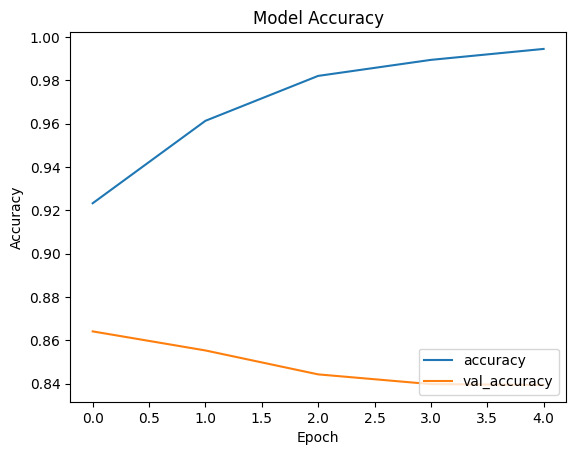

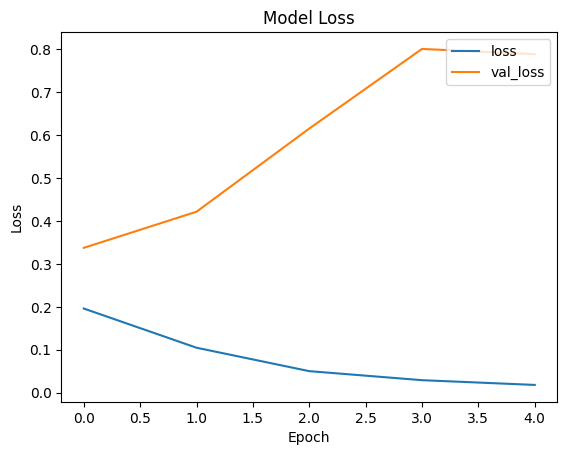

In [25]:
# Fit the TensorFlow model to plot the metrics
history = best_model.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test))

# Display plots
plot_metrics(history)

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


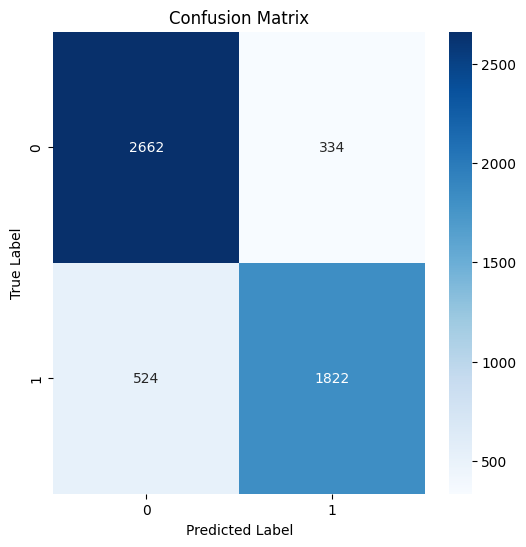

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      2996
           1       0.85      0.78      0.81      2346

    accuracy                           0.84      5342
   macro avg       0.84      0.83      0.84      5342
weighted avg       0.84      0.84      0.84      5342



In [28]:
# Prediksi label untuk test set
y_pred_probs = best_model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# **Deskripsi Proyek: GRU Models untuk Deteksi Sarkasme**

Proyek ini bertujuan untuk membangun model deep learning menggunakan GRU (Gated Recurrent Unit) untuk mendeteksi sarkasme dalam teks, menggunakan dataset DeteksiSarkasme.json. Dalam proyek ini, kita mengembangkan dua model GRU, satu menggunakan PyTorch dan satu menggunakan TensorFlow. Berikut adalah detail implementasi dari proyek ini.

### **Tujuan Proyek**:
Proyek ini bertujuan untuk membangun dan mengevaluasi model GRU untuk mendeteksi apakah suatu kalimat mengandung unsur sarkasme. Model ini diharapkan dapat mengklasifikasikan teks dengan akurat, memisahkan kalimat sarkastik dari kalimat yang tidak sarkastik.

### **Langkah-langkah yang Diambil**:

#### a. **Praproses Data**:
Dataset `DeteksiSarkasme.json` berisi data berupa teks yang telah diberi label apakah kalimat tersebut mengandung sarkasme. Data tersebut diproses dengan menggunakan tokenizer untuk mengonversi teks menjadi representasi numerik yang dapat diproses oleh model deep learning.

#### b. **Membangun Model GRU**:
Model GRU dibangun menggunakan dua framework deep learning yang berbeda: PyTorch dan TensorFlow. Model GRU dipilih karena kemampuannya dalam memproses data berurutan (sequential data) seperti teks, yang sering digunakan dalam NLP (Natural Language Processing).

- PyTorch GRU Model: Model ini dibangun menggunakan PyTorch, dengan lapisan embedding untuk representasi kata, diikuti oleh lapisan GRU, dan akhirnya lapisan fully connected** untuk output.
- TensorFlow GRU Model: Model yang serupa dibangun menggunakan TensorFlow dengan arsitektur yang hampir identik, namun memanfaatkan kerangka kerja Keras di TensorFlow.

#### c. **Evaluasi Model**:
Evaluasi dilakukan menggunakan beberapa metrik performa berikut:
- **Akurasi (Accuracy)**: Mengukur persentase prediksi yang benar.
- **Presisi (Precision)**: Mengukur seberapa banyak dari prediksi positif yang benar-benar positif.
- **Recall**: Mengukur seberapa banyak dari data positif yang berhasil terdeteksi oleh model.
- **F1 Score**: Kombinasi antara presisi dan recall untuk memberikan gambaran yang lebih seimbang.
- **AUC**: Area di bawah kurva ROC, yang mengukur kemampuan model dalam membedakan antara kelas positif dan negatif.

#### d. **Hyperparameter Tuning**:
Untuk TensorFlow, dilakukan hyperparameter tuning menggunakan Keras Tuner untuk mencari kombinasi hyperparameter terbaik, seperti ukuran lapisan embedding, jumlah unit pada lapisan GRU, dan laju pembelajaran (learning rate).

#### e. **Visualisasi**:
Visualisasi dilakukan untuk menampilkan kurva Akurasi dan Loss selama pelatihan, baik untuk data pelatihan (training) maupun data validasi (validation). Ini membantu memantau performa model dan memastikan bahwa model tidak mengalami overfitting.

### **Hasil yang Diperoleh**:

- **Metrik untuk PyTorch**:
  - **Akurasi**: 0.8323
  - **Presisi**: 0.8281
  - **Recall**: 0.7801
  - **F1 Score**: 0.8033
  - **AUC**: 0.8266

- **Metrik untuk TensorFlow**:
  - **Akurasi**: 0.8650
  - **Presisi**: 0.8249
  - **Recall**: 0.8794
  - **F1 Score**: 0.8512
  - **AUC**: 0.8666

Hasil menunjukkan bahwa model TensorFlow memiliki performa yang lebih baik dibandingkan dengan PyTorch dalam hal Akurasi, Recall, F1 Score, dan AUC.

### Penjelasan untuk Setiap Metrik Matematika

1. **Akurasi (Accuracy)**:
   - **Formula**:  
     
$$\text{Akurasi} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Samples}}$$
     
   - **Penjelasan**: Akurasi mengukur seberapa banyak prediksi yang benar dibandingkan dengan total sampel. Dalam hal ini, akurasi adalah rasio prediksi yang benar baik untuk kelas positif (True Positives) maupun kelas negatif (True Negatives) dibandingkan dengan seluruh sampel yang diuji.
   - **Interpretasi**:
     - Akurasi PyTorch adalah 0.8323, artinya sekitar 83.23% dari total data diuji diklasifikasikan dengan benar.
     - **Akurasi TensorFlow** adalah 0.8650, yang menunjukkan bahwa model TensorFlow lebih akurat dalam mengklasifikasikan data dibandingkan model PyTorch.

2. **Presisi (Precision)**:
   - **Formula**:
     
     $$\text{Presisi} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$
     
   - **Penjelasan**: Presisi mengukur seberapa banyak dari semua prediksi positif yang benar-benar positif. Dengan kata lain, dari semua prediksi yang dilakukan sebagai kelas positif, berapa persen yang benar-benar positif.
   - **Interpretasi**:
     - **Presisi PyTorch** adalah 0.8281, yang berarti bahwa sekitar 82.81% dari semua prediksi yang diklasifikasikan sebagai **positif** benar-benar positif.
     - **Presisi TensorFlow** adalah 0.8249, sedikit lebih rendah daripada PyTorch, tetapi masih menunjukkan bahwa sebagian besar prediksi positif adalah benar.

3. **Recall (Sensitivity atau True Positive Rate)**:
   - **Formula**:
     
     $$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$
     
   - **Penjelasan**: Recall mengukur kemampuan model dalam mendeteksi kelas positif. Ini menunjukkan seberapa banyak dari kelas positif yang sebenarnya dapat terdeteksi oleh model.
   - **Interpretasi**:
     - **Recall PyTorch** adalah 0.7801, yang berarti model ini mendeteksi sekitar 78.01% dari seluruh kelas positif yang sebenarnya.
     - **Recall TensorFlow** adalah 0.8794, yang lebih baik daripada PyTorch, menunjukkan bahwa model TensorFlow lebih baik dalam mendeteksi kelas positif.

4. **F1 Score**:
   - **Formula**:
     
     $$F1 \, \text{Score} = 2 \times \frac{\text{Presisi} \times \text{Recall}}{\text{Presisi} + \text{Recall}}$$
     
   - **Penjelasan**: F1 Score adalah rata-rata harmonis antara Presisi dan Recall, yang memberikan gambaran tentang keseimbangan antara keduanya. F1 Score digunakan ketika kita ingin mempertimbangkan kedua metrik tersebut secara bersamaan.
   - **Interpretasi**:
     - **F1 Score PyTorch** adalah 0.8033, yang menunjukkan bahwa model ini memiliki keseimbangan yang cukup baik antara presisi dan recall.
     - **F1 Score TensorFlow** adalah 0.8512, lebih tinggi dari PyTorch, menunjukkan bahwa model TensorFlow lebih baik dalam mencapai keseimbangan antara presisi dan recall.

5. **AUC (Area Under the ROC Curve)**:
   - **Formula**: AUC mengukur area di bawah kurva ROC (Receiver Operating Characteristic), yang menggambarkan kemampuan model untuk membedakan antara kelas positif dan negatif.
   - **Penjelasan**: AUC memberikan gambaran keseluruhan tentang kemampuan model dalam membedakan kelas positif dan negatif. Nilai AUC berkisar antara 0 hingga 1:
     - **AUC = 0.5** berarti model tidak lebih baik dari tebakan acak.
     - AUC = 1 berarti model sempurna dalam membedakan kelas.
   - **Interpretasi**:
     - **AUC PyTorch** adalah 0.8266, yang menunjukkan bahwa model PyTorch memiliki kemampuan yang baik dalam membedakan antara kelas positif dan negatif.
     - **AUC TensorFlow** adalah 0.8666, yang menunjukkan model TensorFlow memiliki kemampuan sedikit lebih baik dalam memisahkan kedua kelas.


### **Kesimpulan**:
Proyek ini berhasil membangun dua model GRU untuk deteksi sarkasme dan melakukan evaluasi terhadap performa masing-masing model menggunakan beberapa metrik. Meskipun kedua model menunjukkan performa yang baik, model **TensorFlow** menunjukkan kinerja yang sedikit lebih unggul dalam hal kemampuan untuk membedakan antara kalimat sarkastik dan tidak sarkastik.

Ini adalah gambaran umum dan analisis dari proyek GRU Models yang dibangun untuk deteksi sarkasme dalam teks. Jika ada pertanyaan lebih lanjut atau bagian yang perlu dijelaskan lebih detail, jangan ragu untuk menghubungi saya!